Download the support file for IS computation.

In [ ]:
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload
def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())
id_to_fn = {
'1z-3wIa4MzQp2fHHn2_1v1ZuI8sYKXrTw': 'inception_score.py',
'1ijo3v_Y-XrV8ytpWRey9PvHy_NV9cTBE': 'test_case_VAE.zip',
'1FZyHINMFqELoTjWUHSwM3krMF1bH3ROV': 'test_case_GAN.zip'
}
# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

In [ ]:
! unzip -q test_case_VAE.zip
! unzip -q test_case_GAN.zip

# VAE
### Load data for part 1.1 VAE


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from torch.optim.lr_scheduler import StepLR
import torchvision.utils as vutils
from torch.utils.data import DataLoader, TensorDataset
from scipy import linalg
from scipy.stats import entropy
import tqdm
import cv2

# FashionMNIST Dataset
train_dataset = datasets.FashionMNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)

# Data Loader (Input Pipeline)
train_batch_size = 100
test_batch_size = 100
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

## Model Definition 

In [ ]:
class VAE(torch.nn.Module):
  def __init__(self, zdim):
    super(VAE,self).__init__()
    ################################
    # Please fill in your code here:
    self.fc1 = nn.Linear(784, 400)
    self.mu = nn.Linear(400, 500)
    self.log_var = nn.Linear(400, 500)
    self.fc3 = nn.Linear(500, 400)
    self.fc4 = nn.Linear(400, 784)
    self.sigmoid = nn.Sigmoid()
    ################################
    
    
  def encode(self, X):
    ################################
    # Please fill in your code here:
    h1 = F.relu(self.fc1(X))
    mean = self.mu(h1)
    log_var = self.log_var(h1)
    ################################
    return mean, log_var

  def decode(self, X):
    ################################
    # Please fill in your code here:
    h3 = F.relu(self.fc3(X))
    X = self.sigmoid(self.fc4(h3))
    ################################
    return X

  def reparameterization(self, mean, log_var):
    ################################
    # Please fill in std, eps and z:
    # std = 
    # eps = 
    # z = 
    ################################
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    z = mean + eps * std
    return z

  def forward(self, X):
    X = X.view(-1,784)
    mean, log_var = self.encode(X)
    z = self.reparameterization(mean, log_var)
    return self.decode(z), mean, log_var




testcase_mean = torch.load('test_case_VAE/mean.pt')
testcase_log_var = torch.load('test_case_VAE/log_var.pt')
# check std
testcase_std = torch.load('test_case_VAE/std.pt')

testcase_eps = torch.load('test_case_VAE/eps.pt')
testcase_z = torch.load('test_case_VAE/z.pt' )


## VAE Train

In [ ]:
# Reconstruction error module
def reconstruction_error(model, test_loader):
 

    model.eval()
    criterion=nn.MSELoss(reduction='sum')
    recon_err = 0
    idx_counter = 0
    for i, (data,_) in enumerate(test_loader):
        data = data.to(device)
  
        recon_batch, mean, log_var = model(data)
        idx_counter+=data.shape[0] # sum up the number of images in test_loader


        data=data.view(-1, 784)
 

        recon_err+= criterion(recon_batch, data)
        
    avg_err = recon_err/idx_counter
    return avg_err




### Reconstruction error + KL divergence losses in VAE (TODO)

In [ ]:
# Return reconstruction error + KL divergence losses
def loss_function(recon_x, x, mu, log_var):


    x=x.view(-1, 784)
    criterion = nn.BCELoss(reduction='sum')
    KLDivergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    totalloss = criterion(recon_x, x) + KLDivergence

    return totalloss,criterion(recon_x, x),KLDivergence


### VAE Training

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Epoch: 0 LR: [0.001]
Train Epoch: 1 0% 	Loss: 554.373398 	Recon_err: 127.72187042236328
Train Epoch: 1 17% 	Loss: 309.414746 	Recon_err: 37.63595962524414
Train Epoch: 1 33% 	Loss: 290.981367 	Recon_err: 30.00016212463379
Train Epoch: 1 50% 	Loss: 279.749648 	Recon_err: 26.99293327331543
Train Epoch: 1 67% 	Loss: 278.548086 	Recon_err: 25.741893768310547
Train Epoch: 1 83% 	Loss: 277.600625 	Recon_err: 24.75446128845215
Epoch: 1 Train loss: 298.9819
Epoch: 1 LR: [0.001]
Train Epoch: 2 0% 	Loss: 275.578672 	Recon_err: 24.244550704956055
Train Epoch: 2 17% 	Loss: 279.657500 	Recon_err: 23.377119064331055
Train Epoch: 2 33% 	Loss: 271.997891 	Recon_err: 22.96121597290039
Train Epoch: 2 50% 	Loss: 270.805215 	Recon_err: 22.93375587463379
Train Epoch: 2 67% 	Loss: 270.182207 	Recon_err: 22.45624351501465
Train Epoch: 2 83% 	Loss: 276.289414 	Recon_err: 22.20569610595703
Epoch: 2 Train loss: 275.1734
Epoch: 2 LR: [0.001]
Train Epoch: 3 0% 	Loss: 277.727461 	Recon_err: 22.224597930908203
Trai

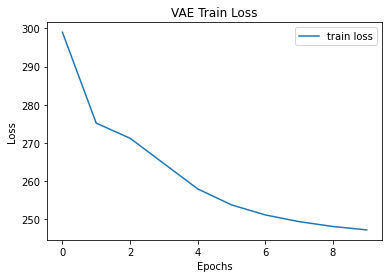

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ZDIM = 500


vae = VAE(ZDIM).to(device)

optimizer = optim.Adam(vae.parameters(), lr = 1e-3)

scheduler = StepLR(optimizer, step_size=10, gamma=0.2)

num_epochs = 10
import pdb
train_loss_list = []
orig_image_list = []
recon_image_list = []
reconst_error = []
BCE_error = []
KLD_error = []

# Define Train loop 
def train(epochs, train_loader, test_loader):

  for epoch in range(epochs):
      vae.train()
      train_loss = 0
      kld_loss = 0
      bce_loss = 0
      print('Epoch:', epoch,'LR:', scheduler.get_lr())
      for batch_idx, (data, _) in enumerate(train_loader):
          data = data.cuda()
          optimizer.zero_grad()

          recon_batch, mean, log_var = vae(data)

          loss,bce,kld = loss_function(recon_batch, data, mean, log_var)
          
          loss.backward()
          bce_loss += bce.item()
          kld_loss += kld.item()
          train_loss += loss.item()
          optimizer.step()

          if batch_idx % 100 == 0:
              recon_err = reconstruction_error(vae, test_loader)
              reconst_error.append(recon_err)
              print('Train Epoch: {} {:.0f}% \tLoss: {:.6f} \tRecon_err: {}'.format(epoch+1, 100. * batch_idx / len(train_loader), loss.item() / len(data), recon_err))
          del data; del recon_batch; del mean; del log_var    
          
      train_loss_list.append(train_loss / len(train_loader.dataset))
      BCE_error.append(bce_loss / len(train_loader.dataset))
      KLD_error.append(kld_loss / len(train_loader.dataset))
      print('Epoch: {} Train loss: {:.4f}'.format(epoch+1, train_loss / len(train_loader.dataset)))
      scheduler.step() 


      if epoch%5==0:
        with torch.no_grad():
          
            x_batch =torch.randn(10*10, ZDIM)
            recon_batch = vae.decode(x_batch.to(device))

        orig_image_list.append(vutils.make_grid(x_batch, nrow=10 ,padding=2, normalize=True))
        recon_image_list.append(vutils.make_grid(recon_batch.view(recon_batch.shape[0], 1 , 28, 28).detach().cpu(),nrow=10 , padding=2, normalize=True))


  checkpoint = {'vae': vae.state_dict()}
  torch.save(checkpoint, '/content/vae_{}.pt'.format(epochs))
train(num_epochs, train_loader, test_loader)


plt.title("VAE Train Loss")
plt.plot(train_loss_list,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()






In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
path = os.path.join('/content/drive/MyDrive/VAE,GANS','vae_epoch')
torch.save({
          'model_state_dict': vae.state_dict(),
          'optimizer_state_dict': optimizer.state_dict()
            }, path)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

ZDIM = 500


vae = VAE(ZDIM).to(device)
optimizer = optim.Adam(vae.parameters(), lr = 1e-3)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/VAE,GANS/vae_epoch')
vae.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])


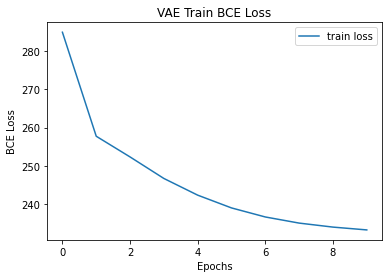

In [ ]:
plt.title("VAE Train BCE Loss")
plt.plot(BCE_error,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("BCE Loss")
plt.legend()
plt.show()

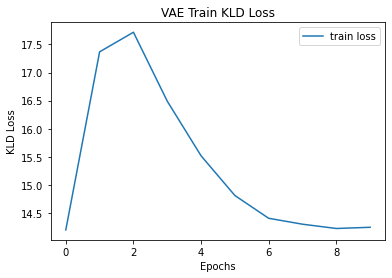

In [ ]:
plt.title("VAE Train KLD Loss")
plt.plot(KLD_error,label="train loss")
plt.xlabel("Epochs")
plt.ylabel("KLD Loss")
plt.legend()
plt.show()

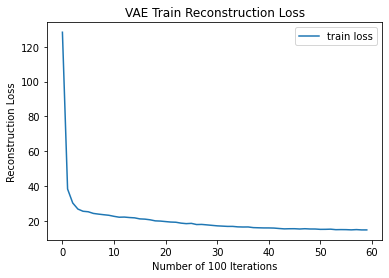

In [ ]:
plt.title("VAE Train Reconstruction Loss")

plt.plot(reconst_error,label="train loss")
plt.xlabel("Number of 100 Iterations")
plt.ylabel("Reconstruction Loss")
plt.legend()
plt.show()

## Qualitative Visualisations

### VAE Testing 

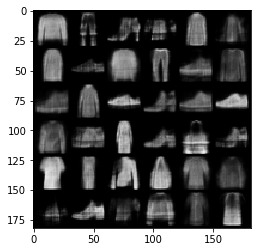

In [ ]:

grid_size = 6 
import torchvision
vae.eval()
sample = torch.randn(36, 500).to(device)
output = vae.decode(sample).cpu()
sample=output.reshape(36,1,28,28)
grid_ip = torchvision.utils.make_grid(sample, nrow=6)
plt.imshow(np.transpose(grid_ip.cpu().detach().numpy(), (1,2,0)), interpolation='nearest')
plt.show()


### Visualize the original vs reconstructed images

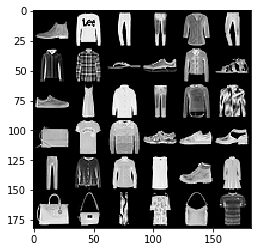

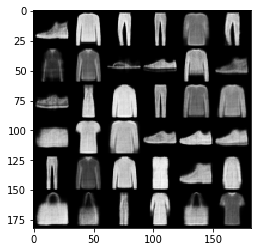

In [ ]:

import torchvision
test_batch_size = 36
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)
vae.eval()
for i, (data,_) in enumerate(test_loader):
  data = data.to(device)

  recon_batch, mean, log_var = vae(data)
  grid_ip = torchvision.utils.make_grid(data, nrow=6)
  plt.imshow(np.transpose(grid_ip.cpu().detach().numpy(), (1,2,0)), interpolation='nearest')
  plt.show()
  recon_batch=recon_batch.reshape(36,1,28,28)
  grid_op = torchvision.utils.make_grid(recon_batch, nrow=6)
  plt.imshow(np.transpose(grid_op.cpu().detach().numpy(), (1,2,0)), interpolation='nearest')
  plt.show()
  break



## Quantitative Evaluation (TODO)

### VAE IS score

The following block create 2 torch dataset.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

evaluate_num = 1000
real_set = []
gen_set = []
test_batch_size = 1
test_dataset = datasets.FashionMNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True)

for idx, data in enumerate(test_loader, 0):
    vae.eval()
    image = data[0]
 
    image= image.to(device)
    gen_image, _, _ = vae(image)

    
    gen_image = gen_image.reshape(-1,28,28).unsqueeze(0)
  
    
    image = image.repeat(1,3,1,1)
    gen_image = gen_image.repeat(1,3,1,1)
    real_set.append(image)
    gen_set.append(gen_image)

        
    if idx == evaluate_num-1:
        break

# make the pytorch dataset
real_set = TensorDataset(torch.cat(real_set))
gen_set = TensorDataset(torch.cat(gen_set))


#### IS


In [ ]:
from inception_score import inception_score
import warnings
warnings.filterwarnings("ignore")

print('real images IS_score:')
print(inception_score(real_set, cuda=True, batch_size=64, resize=True, splits=1))

print('generated images IS_score:')
print(inception_score(gen_set, cuda=True, batch_size=64, resize=True, splits=1))

real images IS_score:
4.296924343616617
generated images IS_score:
2.7922614829085424
